In [1]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [2]:
# Disable jedi autocompleter
%config Completer.use_jedi = False

# Overview

In this section we are building a bear classifier end to end to get exposure to basic high level APIs and have a discussion around deep learning capabilities and constraints. Importantly there is also a discussion about the datablock API.

We use the bing search API having signed up for Azure and gotten a token to allow us to query their service. Alternatively we can use DuckDuckGo as shown below.

### Bing Search

In [3]:
import os
key = os.environ.get('AZURE_SEARCH_KEY', 'ff1bcef22c6a4d5584076df01b888164')

In [7]:
search_images_bing??

In [9]:
def search_images_bing(key, term, min_sz=128, max_images=150):
    # params/headers: REST API format
    # requests.get GET request 
    # raise for status Raises :class:`HTTPError`, if one occurred.
     params = {'q':term, 'count':max_images, 'min_height':min_sz, 'min_width':min_sz}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])

In [ ]:
results = search_images_bing(key, 'grizzly bear')
# attrgot needed since urls are not returned as strings
ims = results.attrgot('contentUrl')
len(ims)

### DuckDuckGo search

In [32]:
def search_images_ddg(key,max_n=200):
     """Search for 'key' with DuckDuckGo and return a unique urls of 'max_n' images
        (Adopted from https://github.com/deepanprabhu/duckduckgo-images-api)
     """
     url        = 'https://duckduckgo.com/'
     params     = {'q':key}
     res        = requests.post(url,data=params)
     searchObj  = re.search(r'vqd=([\d-]+)\&',res.text)
     if not searchObj: print('Token Parsing Failed !'); return
     requestUrl = url + 'i.js'
     headers    = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) Gecko/20100101 Firefox/71.0'}
     params     = (('l','us-en'),('o','json'),('q',key),('vqd',searchObj.group(1)),('f',',,,'),('p','1'),('v7exp','a'))
     urls       = []
     while True:
         try:
             res  = requests.get(requestUrl,headers=headers,params=params)
             data = json.loads(res.text)
             for obj in data['results']:
                 urls.append(obj['image'])
                 max_n = max_n - 1
                 if max_n < 1: return L(set(urls))     # dedupe
             if 'next' not in data: return L(set(urls))
             requestUrl = url + data['next']
         except:
             pass

In [35]:
urls = search_images_ddg('grizzly bear', max_n=100)

In [36]:
len(urls),urls[0]

(100,
 'http://mediad.publicbroadcasting.net/p/kufm/files/styles/x_large/public/201603/grizzly-bear_Nathan-Rupert-CC-BY-NC-ND_0.jpg')

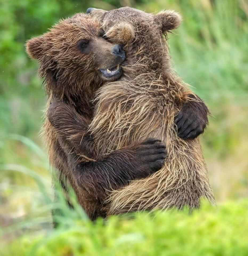

In [37]:
download_url(urls[0], 'images/bear.jpg')
im = Image.open('images/bear.jpg')
im.thumbnail((256,256))
im

### Challenge 1

Download the set of bears using the API to local folders that are appropriately named for each of the bear types.
i.e. folder for grizzlies can search grizzly bear

In [4]:
path = Path('ddg/Bears')
search_terms = ['grizzly bear', 'black bear', 'teddy bear']

In [60]:
# challenge answer, not that path concatenation occurs with '/'

def download_images_to_files(dest_prefix: Path, search_terms: List[str]):
    if not dest_prefix.exists():
        os.makedirs(dest_prefix)
    for search_term in search_terms:
        dest = dest_prefix / search_term.replace(' ', '_')
        urls = search_images_ddg(search_term, max_n=100)
        dest.mkdir(exist_ok=True)
        download_images(dest=dest, urls=urls)

In [5]:
fns = get_image_files(path)

In [6]:
fns

(#300) [Path('ddg/Bears/grizzly_bear/00000004.jpg'),Path('ddg/Bears/grizzly_bear/00000001.png'),Path('ddg/Bears/grizzly_bear/00000002.jpg'),Path('ddg/Bears/grizzly_bear/00000005.jpg'),Path('ddg/Bears/grizzly_bear/00000003.jpg'),Path('ddg/Bears/grizzly_bear/00000008.jpg'),Path('ddg/Bears/grizzly_bear/00000010.jpg'),Path('ddg/Bears/grizzly_bear/00000000.jpg'),Path('ddg/Bears/grizzly_bear/00000011.jpg'),Path('ddg/Bears/grizzly_bear/00000013.jpg')...]

In [7]:
failed = verify_images(fns)
failed

/home/lyft/anaconda3/lib/python3.8/site-packages/PIL/Image.py:2966: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/home/lyft/anaconda3/lib/python3.8/site-packages/PIL/Image.py:2966: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


(#10) [Path('ddg/Bears/grizzly_bear/00000020.jpg'),Path('ddg/Bears/grizzly_bear/00000023.jpg'),Path('ddg/Bears/grizzly_bear/00000064.jpg'),Path('ddg/Bears/grizzly_bear/00000089.jpg'),Path('ddg/Bears/black_bear/00000045.jpg'),Path('ddg/Bears/black_bear/00000092.jpg'),Path('ddg/Bears/teddy_bear/00000013.jpg'),Path('ddg/Bears/teddy_bear/00000011.jpg'),Path('ddg/Bears/teddy_bear/00000044.jpg'),Path('ddg/Bears/teddy_bear/00000086.jpg')]

### How to remove bad images?
python standard library comes with `Path.unlink`

In [8]:
# remove bad images from folders
failed.map(Path.unlink)

(#10) [None,None,None,None,None,None,None,None,None,None]

# Datablock Exploration

https://docs.fast.ai/tutorial.datablock.html

> To build a DataBlock you need to give the library four things: the types of your input/labels, and at least two functions: get_items and splitter. You may also need to include get_x and get_y or a more generic list of getters that are applied to the results of get_items.
Once those are provided, you automatically get a Datasets or a DataLoaders:

Datablock -> DataSets or DataLoaders

In [3]:
from fastai.data.all import *
from fastai.vision.all import *

In [4]:
path = untar_data(URLs.PETS)

In [5]:
path.ls()

(#2) [Path('/home/lyft/.fastai/data/oxford-iiit-pet/images'),Path('/home/lyft/.fastai/data/oxford-iiit-pet/annotations')]

In [6]:
fnames = get_image_files(path/"images")
fnames[0]

Path('/home/lyft/.fastai/data/oxford-iiit-pet/images/Siamese_87.jpg')

In [8]:
def label_func(fname):
    """cat if first letter of file name is upper case"""
    return "cat" if fname.name[0].isupper() else "dog"

In [9]:
# super simple DataBlock that knows how to get items and their targets but doesn't know the types
dblock = DataBlock(get_items=get_image_files, get_y=label_func)

In [10]:
datasets = dblock.datasets(path/'images')

In [11]:
datasets.train[0]

(Path('/home/lyft/.fastai/data/oxford-iiit-pet/images/Bengal_49.jpg'), 'cat')

Now need to tell the datablock that the inputs are images and the targets are categories. 

These types are represented via `blocks` classes such as ImageBlock and CategoryBlock

In [61]:
def ImageBlock(cls=PILImage):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor)

The way we usually build the data block in one go is by answering a list of questions:
 
- what is the types of your inputs/targets? Here images and categories
- where is your data? Here in filenames in subfolders
- does something need to be applied to inputs? Here no
- does something need to be applied to the target? Here the label_func function
- how to split the data? Here randomly
- do we need to apply something on formed items? Here a resize
- do we need to apply something on formed batches? Here no

In [67]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                   get_items=get_image_files, 
                   get_y=label_func,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(224))

In [70]:
pet_datasets = dblock.datasets(path/'images')

In [74]:
pet_dataloader = dblock.dataloaders(path/'images')

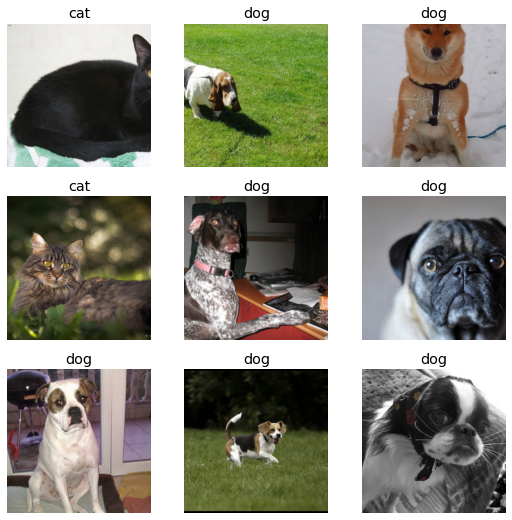

In [75]:
pet_dataloader.show_batch()

# Bears in production

In [16]:
path = Path('ddg/Bears/')

In [14]:
bears_datablock = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                            batch_tfms=aug_transforms(),
                            get_items=get_image_files, 
                            get_y=parent_label, 
                            splitter=RandomSplitter(valid_pct=0.2, seed=42),
                            item_tfms=RandomResizedCrop(224, min_scale=0.7))




In [19]:
dls = bears_datablock.dataloaders(path)

In [22]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/lyft/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/home/lyft/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,1.927506,1.836615,0.465517,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.322468,0.395663,0.120690,00:09
1,0.202591,0.104349,0.051724,00:09
2,0.156885,0.053085,0.034483,00:09
3,0.116079,0.039417,0.034483,00:09


In [23]:
interp = ClassificationInterpretation.from_learner(learn)

## Online Application

In [27]:
#export model to pkl file
learn.export()

In [28]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
# to import
learn_inf = load_learner(path/'export.pkl')